## Module Imports

In [1]:
include("emulation_functions.jl")
using BenchmarkTools
using CSV
using JLD2
using Dates
using MultivariateStats
import MultivariateStats: reconstruct
using GaussianProcesses
using NCDatasets
using DataFrames
using ForwardDiff
using LinearAlgebra
using NamedArrays
using Plots
using Plots.PlotMeasures
using Optimization
using OptimizationOptimJL
using Statistics
using StatsPlots
using Distributions
using Turing
#using Random
using .Threads

## Set File Directory
Set the `directory_of_files` variable below to the path leading to your folder containing all the data and emulator files.

In [3]:
# directory where all files are located. If it is this working directory, set this to "./"
directory_of_files = "../data/"; 
p_names = (:flnr,:slatop,:dleaf,:dsladlai,:leaf_long,:s_vc,:bbbopt,:mbbopt,:smpsc,:smpso,:rholvis,:rholnir,:taulvis,:taulnir,:rhosvis,:rhosnir,:xl,:displar,:z0mr,:vcmaxha,:vcmaxhd,:jmaxha,:jmaxhd,:roota_par,:rootb_par,:grperc)
p_names_dis = (:flnr,:slatop,:leaf_long, :rootb_par)

D = length(p_names_dis)

4

## Load data 

In [5]:
# Dictionaries to make this all neater
output_var_header_names = Dict{String, String}("GPP" => "GPP_NT_VUT_REF", 
                                               "NEE" => "NEE_VUT_REF", 
                                               "LH" => "LE_F_MDS", 
                                               "SH" => "H_F_MDS")
site_names = Dict{String, String}("US_Me2" => "fluxnet_US_Me2_2003_2007", 
                                  "US_Dk3" => "fluxnet_US_Dk3_2003_2007",
                                  "CA_TP4" => "fluxnet_CA_TP4_2003_2007",
                                  "US_Blo" => "fluxnet_US_Blo_2003_2007",
    );

## Load default parameters

In [6]:
p_default=[0.0509,0.01,0.04,0.0006,1.5,20.72,10000,9,-255000,-66000,0.07,0.35,0.05,0.1,0.16,0.39,0.01,0.67,0.055,72000,200000,50000,200000,3,1.25,0.3]
elements = ["flnr","slatop","dleaf","dsladlai","leaf_long","s_vc","bbbopt","mbbopt","smpsc","smpso","rholvis","rholnir","taulvis",
            "taulnir","rhosvis","rhosnir","xl","displar","z0mr","vcmaxha","vcmaxhd","jmaxha","jmaxhd","roota_par","rootb_par","grperc"]
elements_4par = ["flnr","slatop","leaf_long","rootb_par"]
p_hard = (  flnr =      [0.04, 0.3],                         
            slatop =    [0.003, 0.03],
            dleaf =     [0.03, 0.3],
            dsladlai =  [0.0002, 0.0035],
            leaf_long = [1.0, 12.0],
            s_vc =      [16.0,32.0],
            bbbopt =    [16000.0,60000.0],
            mbbopt =    [4.5, 15],
            smpsc =     [-642000.0, -125000.0],
            smpso =     [-125000.0, -17500.0],
            rholvis =   [0.025, 0.25],
            rholnir =   [0.25,0.55],
            taulvis =   [0.005,0.20],
            taulnir =   [0.15,0.45],
            rhosvis =   [0.05,0.30],
            rhosnir =   [0.20,0.75],
            xl =        [-0.5,0.375],
            displar =   [0.6,0.85],
            z0mr =      [0.04,0.09],
            vcmaxha =   [45000.0,90000.0],
            vcmaxhd =   [198000.0, 202000.0],
            jmaxha =    [30000.0,65000.0],
            jmaxhd =    [198000.0, 202000.0],
            roota_par = [2.0,18.0],
            rootb_par = [0.5,6.0],
            grperc =    [0.125,0.375] );

p_hard = [getproperty(p_hard, pn) for pn in propertynames(p_hard)];
p_hard_l = mapreduce(permutedims, vcat, p_hard)[:, 1];
p_hard_u = mapreduce(permutedims, vcat, p_hard)[:, 2];
p_norm = (p_default.- p_hard_l) ./ (p_hard_u .- p_hard_l)

26-element Vector{Float64}:
  0.041923076923076924
  0.25925925925925924
  0.03703703703703704
  0.1212121212121212
  0.045454545454545456
  0.29499999999999993
 -0.13636363636363635
  0.42857142857142855
  0.7485493230174082
  0.5488372093023256
  0.2
  0.3333333333333332
  0.23076923076923078
 -0.1666666666666666
  0.44
  0.3454545454545454
  0.5828571428571429
  0.28000000000000025
  0.3
  0.6
  0.5
  0.5714285714285714
  0.5
  0.0625
  0.13636363636363635
  0.7

## NOTE: 
#### `output_of_interest`
+ "GPP"
+ "NEE"
+ "LH"
+ "SH"


In [8]:
# == SPECIFY THESE PARAMETERS TO SELECT OUTPUT VAR, SITE EMULATOR, AND CALIBRATION SITE OF INTEREST ===
c_site1_to_calibrate_to = "US_Me2"
c_site2_to_calibrate_to = "US_Dk3"
c_site3_to_calibrate_to = "US_Blo"
c_site4_to_calibrate_to = "CA_TP4"
c_site5_to_calibrate_to = "US_NR1"
c_site6_to_calibrate_to = "CA_Qfo"
c_site7_to_calibrate_to = "CA_Obs"
c_site8_to_calibrate_to = "CA_TP1"
c_site9_to_calibrate_to = "CA_TP2"
c_site10_to_calibrate_to = "CA_TP3"

t_site1_to_predict_to = "CA_Qfo"
output_of_interest = "GPP"

# Assertions to make sure we specified our data okay
#@assert site_of_emulator != site_to_calibrate_to
#@assert haskey(site_names, site_of_emulator) 
#@assert haskey(site_names, site_to_calibrate_to)

"GPP"

In [11]:
#site =  site_names[site_to_calibrate_to]
output = output_var_header_names[output_of_interest]
begin_date = "2003" # Begin date of fluxnet data file (in case this changes in the future)
end_date = "2007" # End data of fluxnet data file (in case this changes in the future)

"2007"

In [12]:
function calculate_10day_average(data0)
    num_years = 5 
    monthday=[10, 10,11,10,10,8,10,10,11,10,10,10,10,10,11,10,10,10,10,10,11,10,10,11,10,10,10,10,10,11,10,10,10,10,10,11];
    monthly_average = Vector{Float64}()
    end_day=0
    for year in 1:num_years
        start_day=end_day+1
        for month in 1:36
            end_day = start_day + monthday[month]-1
            temp=mean(filter(!isnan,data0[start_day:end_day,:]), dims=1)
            push!(monthly_average,temp[1])
            start_day=end_day+1
        end
    end
    return monthly_average
end

calculate_10day_average (generic function with 1 method)

In [14]:
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site1_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site1_GPP = Array(data[!, "GPP_NT_VUT_REF"])
id_1=findall(y_site1_GPP.<0)
y_site1_GPP[id_1].=0
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site1_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site1_NEE = Array(data[!, "NEE_VUT_REF"])
#id_2=findall(y_site1_NEE.<0)
#y_site1_NEE[id_2].=0
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site1_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site1_FSH = Array(data[!, "H_F_MDS"])
#id_3=findall(y_site1_FSH.<0)
#y_site1_FSH[id_3].=0
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site1_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site1_LH = Array(data[!, "LE_F_MDS"]);
#id_4=findall(y_site1_LH.<0)
#y_site1_LH[id_4].=0


In [18]:
GPP_01 = calculate_10day_average(y_site1_GPP)
NEE_01 = calculate_10day_average(y_site1_NEE)
FSH_01 = calculate_10day_average(y_site1_FSH)
LH_01 = calculate_10day_average(y_site1_LH)


Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)


180-element Vector{Float64}:
 12.382442999999999
  9.210005
 22.432102727272728
 11.999566999999999
 18.717375
 22.1399
 27.24223
 34.53917
 39.72402727272728
 29.98108
 40.022459999999995
 34.43771
 34.63343
  ⋮
 22.72415
 19.717852
 21.755969999999998
 30.007879999999993
 32.15707
 28.799963636363643
 30.05639
 35.535591999999994
 38.36195
 11.491902
 22.019117
 31.105345454545454

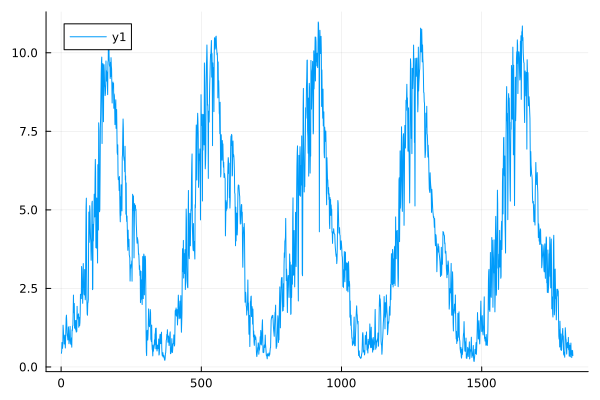

In [19]:
ensembles0 = CSV.read("../data/parameters_normalized_emulator_result_US_Me2_GPP_200_4par.txt", DataFrame; header = false, transpose=true);
GPP1 = Matrix(ensembles0)'*24*3600
ensembles_mGPP1 = mean(GPP1, dims=1)
GPP_Me2_be_200=GPP1[:,144]
plot(GPP_Me2_be_200)

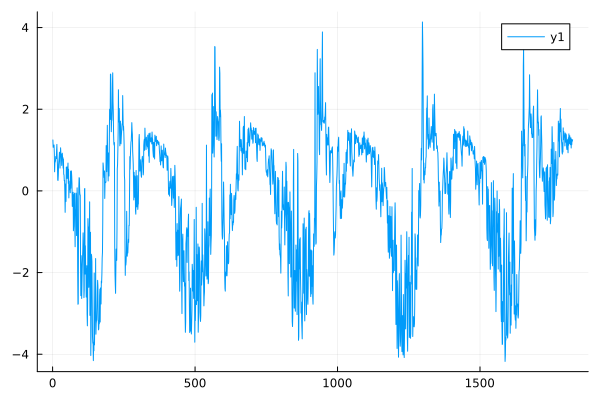

In [20]:
ensembles0 = CSV.read("../data/parameters_normalized_emulator_result_US_Me2_NEE_200_4par.txt", DataFrame; header = false, transpose=true);
NEE1 = Matrix(ensembles0)'*24*3600
ensembles_mNEE1 = mean(NEE1, dims=1)
NEE_Me2_be_200=NEE1[:,136]
plot(NEE_Me2_be_200)

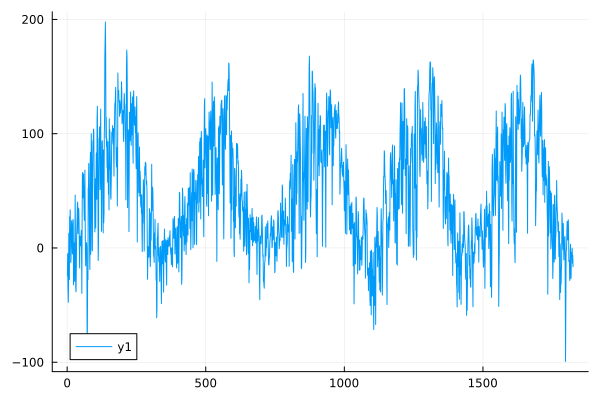

In [21]:
ensembles0 = CSV.read("../data/parameters_normalized_emulator_result_US_Me2_FSH_200_4par.txt", DataFrame; header = false, transpose=true);
FSH1 = Matrix(ensembles0)'
ensembles_mFSH1 = mean(FSH1, dims=1)
FSH_Me2_be_200=FSH1[:,148]
plot(FSH_Me2_be_200)

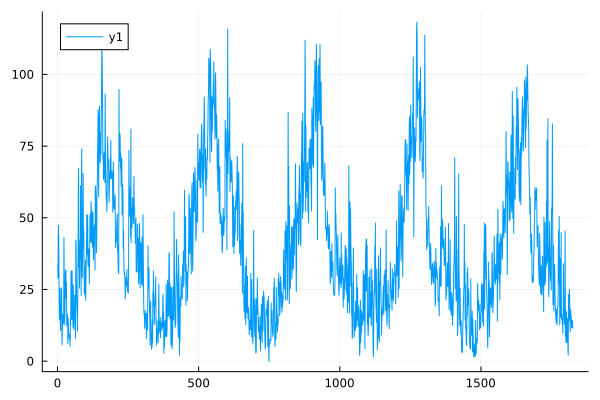

In [22]:
ensembles0 = CSV.read("../data/parameters_normalized_emulator_result_US_Me2_LH_200_4par.txt", DataFrame; header = false, transpose=true);
LH1 = Matrix(ensembles0)'
ensembles_mLH1 = mean(LH1, dims=1)
LH_Me2_be_200=LH1[:,184]
plot(LH_Me2_be_200)

In [23]:
GPP_01_be_ens=calculate_10day_average(GPP_Me2_be_200)
NEE_01_be_ens=calculate_10day_average(NEE_Me2_be_200)
FSH_01_be_ens=calculate_10day_average(FSH_Me2_be_200)
LH_01_be_ens=calculate_10day_average(LH_Me2_be_200)

a1=std(y_site1_GPP-GPP_Me2_be_200)
iid_normal_noise1 = a1*randn(1825)
GPP_01_be=calculate_10day_average(GPP_Me2_be_200+iid_normal_noise1)
a2=std(y_site1_NEE-NEE_Me2_be_200)
iid_normal_noise2 = a2*randn(1825)
NEE_01_be=calculate_10day_average(NEE_Me2_be_200+iid_normal_noise2)
a3=std(y_site1_FSH-FSH_Me2_be_200)
iid_normal_noise3 = a3*randn(1825)
FSH_01_be=calculate_10day_average(FSH_Me2_be_200+iid_normal_noise3)
a4=std(y_site1_LH-LH_Me2_be_200)
iid_normal_noise4 = a4*randn(1825)
LH_01_be=calculate_10day_average(LH_Me2_be_200+iid_normal_noise4)

Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)


180-element Vector{Float64}:
 29.071428682247802
 12.355474913198965
 20.982309343852094
 14.383957746745528
 19.445682848585292
 23.257406661543847
 28.086574528911473
 29.187388926963997
 50.670828119894736
 27.36998186432502
 41.076679257936405
 38.96141123079621
 40.556649553958785
  ⋮
 28.838124017616614
 23.220389722569763
 41.58323375157953
 49.48063460462913
 39.989866048513804
 26.266904718622854
 18.371498150597304
 28.252929141578573
 16.516705895141037
 12.733575417081227
  7.173820659149314
 13.354965229615358

## Load emulator (all GPs used in reconstruction)

In [27]:
emulator_filename1 = "./emulator_GPP_US_Me2_200_4par.jld2";
@load emulator_filename1 array_GP pca_fit μ_z σ_z
emulator_components1 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);
emulator_filename2 = "./emulator_NEE_US_Me2_200_4par.jld2";
@load emulator_filename2 array_GP pca_fit μ_z σ_z
emulator_components2 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);
emulator_filename3 = "./emulator_FSH_US_Me2_200_4par.jld2";
@load emulator_filename3 array_GP pca_fit μ_z σ_z
emulator_components3 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);
emulator_filename4 = "./emulator_LH_US_Me2_200_4par.jld2";
@load emulator_filename4 array_GP pca_fit μ_z σ_z
emulator_components4 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);

┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64}} saved in the file but not present in the type in the workspace:
│ 
│ dim,
│ 
│ Data in these fields will not be accessible
└ @ JLD2 C:\Users\IGB\.julia\packages\JLD2\SgtOb\src\data\reconstructing_datatypes.jl:241
┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64}} saved in the file but not present in the type in the workspace:
│ 
│ dim,
│ 
│ Data in these fields will not be accessible
└ @ JLD2 C:\Users\IGB\.julia\packages\JLD2\SgtOb\src\data\reconstructing_datatypes.jl:241
┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64}} saved in the file but not present in the type in the workspace:
│ 
│ dim,
│ 
│ Data in these fields will not be accessible
└ @ JLD2 C:\Users\IGB\.julia\packages\JLD2\SgtOb\src\data\reconstructing_datatypes.jl:241
┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64

## Bayesian Parameter Calibration

## Create probabilistic model

Our likelihood looks like linear regression and features discrepency terms $\beta_0$ and $\beta_1$ in addition to noise term $\epsilon$.

### Likelihood: 
$$y \sim \beta_1 GP(\theta)  + \epsilon, \qquad $$
$$\epsilon \stackrel{iid}{\sim} N(0,\sigma^2)$$

for now we assume a known $\sigma$, but we could estimate this parameter as well. $y$ is any quantity of interest predicted by the GP, $\theta$ are the model parameters (from the ELM model, the set of 26 params)

### Priors: 

$$\theta \sim p(\theta)$$ 
$$p(\theta) = Normal(0.5,0.25)$$
$$\log(\sigma) \sim N(\log 1, ((\log 2)/2)^2)$$

And I chose Normal priors for the regression parameters and LogNormal for the standard deviation. 


Define Prior distributions

ZJ: I change the priors and define the prob_model for each site, as the emulators are different

### Qoi 1

In [29]:
#try other priors and define the model (emulator) outside for final validation (sample observation & simulated observation)
function priors(num_params)
    return filldist( Truncated(Normal(0.5,0.25), 0,1), num_params)
end
model_1(θ,N_PCA)= calibration_emulator1(θ, emulator_components1, N_PCA);

Q(y)=mean(y)

Q (generic function with 1 method)

In [32]:
@model function prob_model_1(y, num_params, N_PCA)
    # Define the priors
    p ~ priors(num_params)
    #β_0 ~ Normal(0, 1/3)
    β_1 ~ Uniform(0.9,1.1)
    σ ~ LogNormal(log(1), log(2)/2)
    
    θ = reshape(p, 1,length(p)) # GP is very picky about dimensions, so we need to reshape here
    m=model_1(θ,N_PCA)
    
    y ~ MvNormal(β_1*m, σ^2*I )
    return Q(m)
end 

prob_model_1 (generic function with 2 methods)

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain = 5
model = prob_model_1(GPP_01, N_param, 12)
#model = prob_model_1(, N_param, 12)
@time chain1 = Turing.sample(model, alg, strategy, N_sample, N_chain; progress=true)
chain1 = replacenames(chain1, Dict("p[$i]" => p_names_dis[i] for i in 1:D))
@save "US_Me2_GPP_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain1

### Qoi 2

In [35]:
#try other priors and define the model (emulator) outside for final validation (sample observation & simulated observation)
function priors(num_params)
    return filldist( Truncated(Normal(0.5,0.25), 0,1), num_params)
end
model_2(θ,N_PCA)= calibration_emulator1(θ, emulator_components2, N_PCA);

Q(y)=mean(y)

Q (generic function with 1 method)

In [36]:
@model function prob_model_2(y, num_params, N_PCA)
    # Define the priors
    p ~ priors(num_params)
    #β_0 ~ Normal(0, 1/3)
    β_1 ~ Uniform(0.9,1.1)
    σ ~ LogNormal(log(1), log(2)/2)
    θ = reshape(p, 1,length(p)) # GP is very picky about dimensions, so we need to reshape here
    m=model_2(θ,N_PCA)
    y ~ MvNormal(β_1*m, σ^2*I )
    return Q(m)
end 

prob_model_2 (generic function with 2 methods)

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain = 5
model = prob_model_2(NEE_01, N_param, 12)
@time chain2 = Turing.sample(model, alg, strategy, N_sample, N_chain; progress=true)
chain2 = replacenames(chain2, Dict("p[$i]" => p_names_dis[i] for i in 1:D))
@save "US_Me2_NEE_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain2

### Qoi 3

In [37]:
#try other priors and define the model (emulator) outside for final validation (sample observation & simulated observation)
function priors(num_params)
    return filldist( Truncated(Normal(0.5,0.25), 0,1), num_params)
end
model_3(θ,N_PCA)= calibration_emulator1(θ, emulator_components3, N_PCA)/3600/24;

Q(y)=mean(y)

Q (generic function with 1 method)

In [38]:
@model function prob_model_3(y, num_params, N_PCA)
    # Define the priors
    p ~ priors(num_params)
    β_1 ~ Uniform(0.9,1.1)
    σ ~ LogNormal(log(1), log(2)/2)
    
    θ = reshape(p, 1,length(p)) # GP is very picky about dimensions, so we need to reshape here
    m=model_3(θ,N_PCA)
    
    y ~ MvNormal(β_1*m, σ^2*I )
    return Q(m)
end 

prob_model_3 (generic function with 2 methods)

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain =5
model = prob_model_3(FSH_01, N_param, 12)
@time chain3 = Turing.sample(model, alg, strategy, N_sample, N_chain; progress=true)
chain3 = replacenames(chain3, Dict("p[$i]" => p_names_dis[i] for i in 1:D))
@save "US_Me2_FSH_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain3


### Qoi 4

In [46]:
#try other priors and define the model (emulator) outside for final validation (sample observation & simulated observation)
function priors(num_params)
    return filldist( Truncated(Normal(0.5,0.25), 0,1), num_params)
end
model_4(θ,N_PCA)= calibration_emulator1(θ, emulator_components4, N_PCA)/3600/24;

Q(y)=mean(y)

Q (generic function with 1 method)

In [48]:
@model function prob_model_4(y, num_params, N_PCA)
    # Define the priors
    p ~ priors(num_params)
    β_1 ~ Uniform(0.9,1.1)
    σ ~ LogNormal(log(1), log(2)/2)
    
    θ = reshape(p, 1,length(p)) # GP is very picky about dimensions, so we need to reshape here
    m=model_4(θ,N_PCA)
    
    y ~ MvNormal(β_1*m, σ^2*I )
    return Q(m)
end 

prob_model_4 (generic function with 2 methods)

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample = 5000
N_chain = 5
model = prob_model_4(LH_01, N_param, 12)
@time chain4 = Turing.sample(model, alg, strategy, N_sample, N_chain; progress=true)
chain4 = replacenames(chain4, Dict("p[$i]" => p_names_dis[i] for i in 1:D))
@save "US_Me2_LH_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain4

In [ ]:
@load "US_Me2_GPP_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain1
achain1=Array(chain1)
@load "US_Me2_NEE_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain2
achain2=Array(chain2)
@load "US_Me2_FSH_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain3
achain3=Array(chain3)
@load "US_Me2_LH_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain4
achain4=Array(chain4)

In [ ]:
achain1=Array(chain1[:,:,1])
achain2=Array(chain2[:,:,1])
achain3=Array(chain3[:,:,1])
achain4=Array(chain4[:,:,1])
println(size(achain1))

In [ ]:
plt1=corrplot(achain1[:,1:4],  axis=([], true), color=:blue, fillcolor=cgrad(),title="  ", titlefontsize=50,label=["flnr","slatop","leaf_long","rootb_par"],left_margin=5mm)

In [ ]:
plt2=corrplot(achain2[:,1:4],  axis=([], true), color=:blue, fillcolor=cgrad(),title="  ", titlefontsize=50,label=["flnr","slatop","leaf_long","rootb_par"],left_margin=5mm)

In [ ]:
plt3=corrplot(achain3[:,1:4],  axis=([], true), color=:blue, fillcolor=cgrad(),title="  ", titlefontsize=50,label=["flnr","slatop","leaf_long","rootb_par"],left_margin=5mm)

In [ ]:
plt4=corrplot(achain4[:,1:4],  axis=([], true), color=:blue, fillcolor=cgrad(),title="  ", titlefontsize=50,label=["flnr","slatop","leaf_long","rootb_par"],left_margin=5mm)

In [ ]:
plt=plot(plt1,plt2,plt3,plt4,layout=(2,2),left_margin=10mm,bottom_margin=5mm,size=(1000, 800))

savefig(plt,"figS4_pairplots_20250927.pdf")

### Posterior predictions / observing system simulation experiments (OSSEs)

OSSE parameter sampling from posterior distributions

In [50]:
N_samp0 = 1000

1000

In [52]:
@load "US_Me2_GPP_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain1
achain1=Array(chain1)
@load "US_Me2_NEE_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain2
achain2=Array(chain2)
@load "US_Me2_FSH_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain3
achain3=Array(chain3)
@load "US_Me2_LH_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain4
achain4=Array(chain4)

25000×6 Matrix{Float64}:
 0.287897   0.794978  0.0511322  0.341514  0.906275  11.3392
 0.208245   0.814427  0.0460246  0.272622  0.916294  10.9004
 0.179024   0.81826   0.0512264  0.336868  0.938901  10.7187
 0.107888   0.762989  0.132584   0.310385  0.90481   10.9524
 0.221726   0.776021  0.109883   0.304032  0.900533  10.6904
 0.149514   0.772236  0.140499   0.334347  0.905304  11.3256
 0.210319   0.754762  0.084753   0.316852  0.906412  12.5069
 0.187246   0.924963  0.10513    0.391464  0.914052  12.268
 0.134997   0.913163  0.137349   0.426576  0.915727  11.5233
 0.109846   0.948554  0.178753   0.350614  0.921393  11.7394
 0.248715   0.905917  0.0714923  0.458597  0.905211  12.9426
 0.0758025  0.954382  0.213042   0.321883  0.905094  11.5056
 0.129522   0.943981  0.146279   0.474594  0.909151  12.1391
 ⋮                                                    ⋮
 0.109184   0.675782  0.155152   0.500176  0.900479  10.8322
 0.147588   0.702918  0.119726   0.569901  0.904792  10.8454
 0.08

In [53]:
p_samp1 = achain1[Turing.sample(1:size(achain1,1), N_samp0),:]
p_samp2 = achain2[Turing.sample(1:size(achain1,1), N_samp0),:]
p_samp3 = achain3[Turing.sample(1:size(achain1,1), N_samp0),:]
p_samp4 = achain4[Turing.sample(1:size(achain1,1), N_samp0),:]

1000×6 Matrix{Float64}:
 0.179743     0.551266  0.1019     0.284791  0.922419  11.7265
 0.190602     0.739081  0.104497   0.29712   0.902489  10.9113
 0.148287     0.896369  0.120369   0.315704  0.903793  11.6646
 0.0419611    0.297204  0.21966    0.38335   0.90857   10.9902
 0.29365      0.8492    0.0260896  0.305417  0.900886  10.7054
 0.0064263    0.298359  0.227375   0.383107  0.95547   11.1979
 0.141609     0.77715   0.114384   0.358484  0.902743  10.8064
 0.267337     0.830763  0.0144081  0.264509  0.903994  11.1157
 0.227445     0.750756  0.0465139  0.254466  0.90706   11.6772
 0.150171     0.557507  0.139986   0.308964  0.905954  10.7365
 0.208254     0.719891  0.0388929  0.271823  0.900615  11.1967
 0.01352      0.282502  0.187193   0.31332   0.907313  10.0568
 0.189903     0.836053  0.0794714  0.331943  0.903354  10.8054
 ⋮                                                      ⋮
 0.242119     0.818582  0.0515152  0.305211  0.914504  10.8833
 0.0422115    0.26136   0.256814   0

In [54]:
N_param=4
chain_site1_prior = Turing.sample(prob_model_1(GPP_01,N_param,12), Prior(), 5000)
chain_site1_prior = replacenames(chain_site1_prior, Dict("p[$n]" => p_names_dis[n] for n in 1:D))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (5000×7×1 Array{Float64, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 9.33 seconds
Compute duration  = 9.33 seconds
parameters        = flnr, slatop, leaf_long, rootb_par, β_1, σ
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

        flnr    0.5002    0.2193     0.0031    0.0029   5214.1615    0.9998    ⋯
      slatop    0.5050    0.2202     0.0031    0.0028   5129.0521    0.9998    ⋯
   leaf_long    0.5035    0.2231     0.0032    0.0033   4976.6853    1.0001    ⋯
   rootb_par    0.5022    0.2177     0.0031    0.0034   4910.3298    0.9998    ⋯
         β_1    0.9993    0.0578     0.0008    0.0008   4614.7837    0.9998    ⋯
           σ    1.0586    0.3817     0.0054    0.0054   4931.8904    1.0004    ⋯
                                                      

In [55]:
achain0 = Array(chain_site1_prior)
p_samp0 = achain0[Turing.sample(1:size(achain0,1), N_samp0),:]

1000×6 Matrix{Float64}:
 0.815738  0.704264  0.356646   0.954719   0.999396  1.21011
 0.873225  0.569935  0.698242   0.778354   0.937093  0.831151
 0.513892  0.200118  0.333125   0.362477   0.915244  1.20518
 0.615911  0.483345  0.374691   0.732626   1.05252   0.58067
 0.53478   0.506257  0.317714   0.558224   0.997849  0.618521
 0.264689  0.759576  0.949822   0.534643   0.959376  0.879747
 0.250933  0.57222   0.76721    0.275822   0.964083  0.855631
 0.777749  0.864895  0.935203   0.550484   0.956861  1.35729
 0.99555   0.445346  0.788225   0.562364   1.00731   0.639263
 0.711127  0.174394  0.678614   0.561041   0.925865  0.837001
 0.51291   0.60479   0.778413   0.414797   0.936627  1.44983
 0.30109   0.942869  0.383493   0.479359   1.00015   0.538536
 0.202083  0.229806  0.461165   0.602886   0.954166  2.04802
 ⋮                                                   ⋮
 0.639684  0.916546  0.199221   0.471847   1.09468   1.03099
 0.628927  0.576631  0.632927   0.278531   1.02617   0.77939

In [56]:
function simulate_observations(N, samples, model,N_PCA)
    N_samp = size(samples,1)
    y_sim = zeros(N, N_samp)
    @threads for i = 1:N_samp
       y_sim[:,i] .= sample_observation(samples[i,:], model,N_PCA)
    end
    y_sim
end

simulate_observations (generic function with 1 method)

In [59]:
using Statistics
using Distributions

# Define the function to calculate the 95% confidence interval
function confidence_interval(data::Vector{Float64}, confidence_level::Float64=0.05)
    # Sample mean
    mean_value = mean(data)

    # Sample standard deviation
    std_dev = std(data)

    # Sample size
    n = length(data)

    # Standard error of the mean
    sem = std_dev / sqrt(n)

    # For the specified confidence interval, the critical value from the t-distribution
    # Degrees of freedom: n - 1
    df = n - 1
    alpha = 1 - confidence_level
    t_critical = quantile(TDist(df), 1 - alpha / 2)

    # Margin of error
    margin_of_error = t_critical * sem

    # Confidence interval
    lower_bound = quantile(data,0.025)
    upper_bound = quantile(data,0.975)
    return (lower_bound, upper_bound)
end

confidence_interval (generic function with 2 methods)

In [60]:
# Define a function to calculate RMSE
function rmse(actual, predicted)
    n = length(actual)
    sqrt(sum((actual .- predicted).^2) / n)
end

rmse (generic function with 1 method)

In [61]:
# Define a function to calculate RMSE, NRMSE, and PRMSE
function rmse(actual, predicted; method="percentage")
    n = length(actual)
    rmse_value = sqrt(sum((actual .- predicted).^2) / n)

    if method == "range"
        # Normalized by range (max - min)
        norm_rmse = rmse_value / (maximum(actual) - minimum(actual))
    elseif method == "percentage"
        norm_rmse = (rmse_value / mean(actual)) 
    else
        error("Invalid method. Choose 'range' or 'percentage'.")
    end

    return norm_rmse
end

rmse (generic function with 1 method)

In [62]:
# Define a function to calculate RMSE, NRMSE, and PRMSE
function rmse_nee(actual, predicted; method="percentage")
    n = length(actual)
    rmse_value = sqrt(sum((actual .- predicted).^2) / n)

    if method == "range"
        # Normalized by range (max - min)
        norm_rmse = rmse_value / (maximum(actual) - minimum(actual))
    elseif method == "percentage"
        # Normalized by mean (percentage RMSE)
        norm_rmse = (rmse_value / mean(abs.(actual)))
    else
        error("Invalid method. Choose 'range' or 'percentage'.")
    end

    return norm_rmse
end

rmse_nee (generic function with 1 method)

OSSE prediction at the same site

In [64]:
ELM_Me2 = Dataset("US_Me2_GPP_g0001_g1300_2003_2007_res05.nc")
t = ELM_Me2["time"]
time1=year.(t)+dayofyear.(t)/365;

In [65]:
using GLMakie
using CairoMakie

In [66]:
fig = Figure(size= (1000, 750));

In [67]:
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_1(θ,N_PCA)
    err=a1*randn(length(m))
    y = β_1*m +err
end
y_sim_1_1 = simulate_observations(180, p_samp1, model_1, 12)
y_sim_1_1_prior = simulate_observations(180, p_samp0, model_1, 12)
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_2(θ,N_PCA)
    err=a2*randn(length(m))
    y = β_1*m +err
end
y_sim_2_2 = simulate_observations(180, p_samp2, model_2, 12)
y_sim_2_2_prior = simulate_observations(180, p_samp0, model_2, 12)
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_3(θ,N_PCA)
    err=a3*randn(length(m))
    y = β_1*m +err
end
y_sim_3_3 = simulate_observations(180, p_samp3, model_3, 12)
y_sim_3_3_prior = simulate_observations(180, p_samp0, model_3, 12)
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_4(θ,N_PCA)
    err=a4*randn(length(m))
    y = β_1*m +err
end
y_sim_4_4 = simulate_observations(180, p_samp4, model_4, 12)
y_sim_4_4_prior = simulate_observations(180, p_samp0, model_4, 12)

180×1000 Matrix{Float64}:
  37.6916   33.5003    21.8514    40.9734   …   50.0379   48.8123   22.1379
  -3.86977   2.51541   18.6302    17.1537       67.1194   -3.43406  44.3888
  38.9953   14.8381    47.7199    21.3954       37.9578   29.7863    3.90336
  -6.26645  -2.03762  -10.8447   -15.5701      -13.3157   11.0922   25.2362
  32.5695   34.0301     2.13474   29.8973       36.8273    7.64616  -5.09991
  29.8728    1.63716   25.9485    30.0034   …   37.1823   27.4814    5.25138
  36.4982   15.4193    32.1225    27.4358        6.13978  29.4561   28.6633
  33.2986   43.1388    25.5198    55.8704       46.3841   62.7134   56.0079
  50.3679   52.6158    74.2766    69.6838      127.151    36.6729   73.0623
  52.5242   43.6474    63.2562    41.2688       49.5805   54.7119   40.0411
  45.3141   72.0306    70.5681    39.8624   …   65.7658   32.8209   46.1581
  51.2038   69.1958    73.2285    63.2696       66.8945   43.5253   35.9037
 100.984    44.7696    56.1732    72.5654       59.8155   5

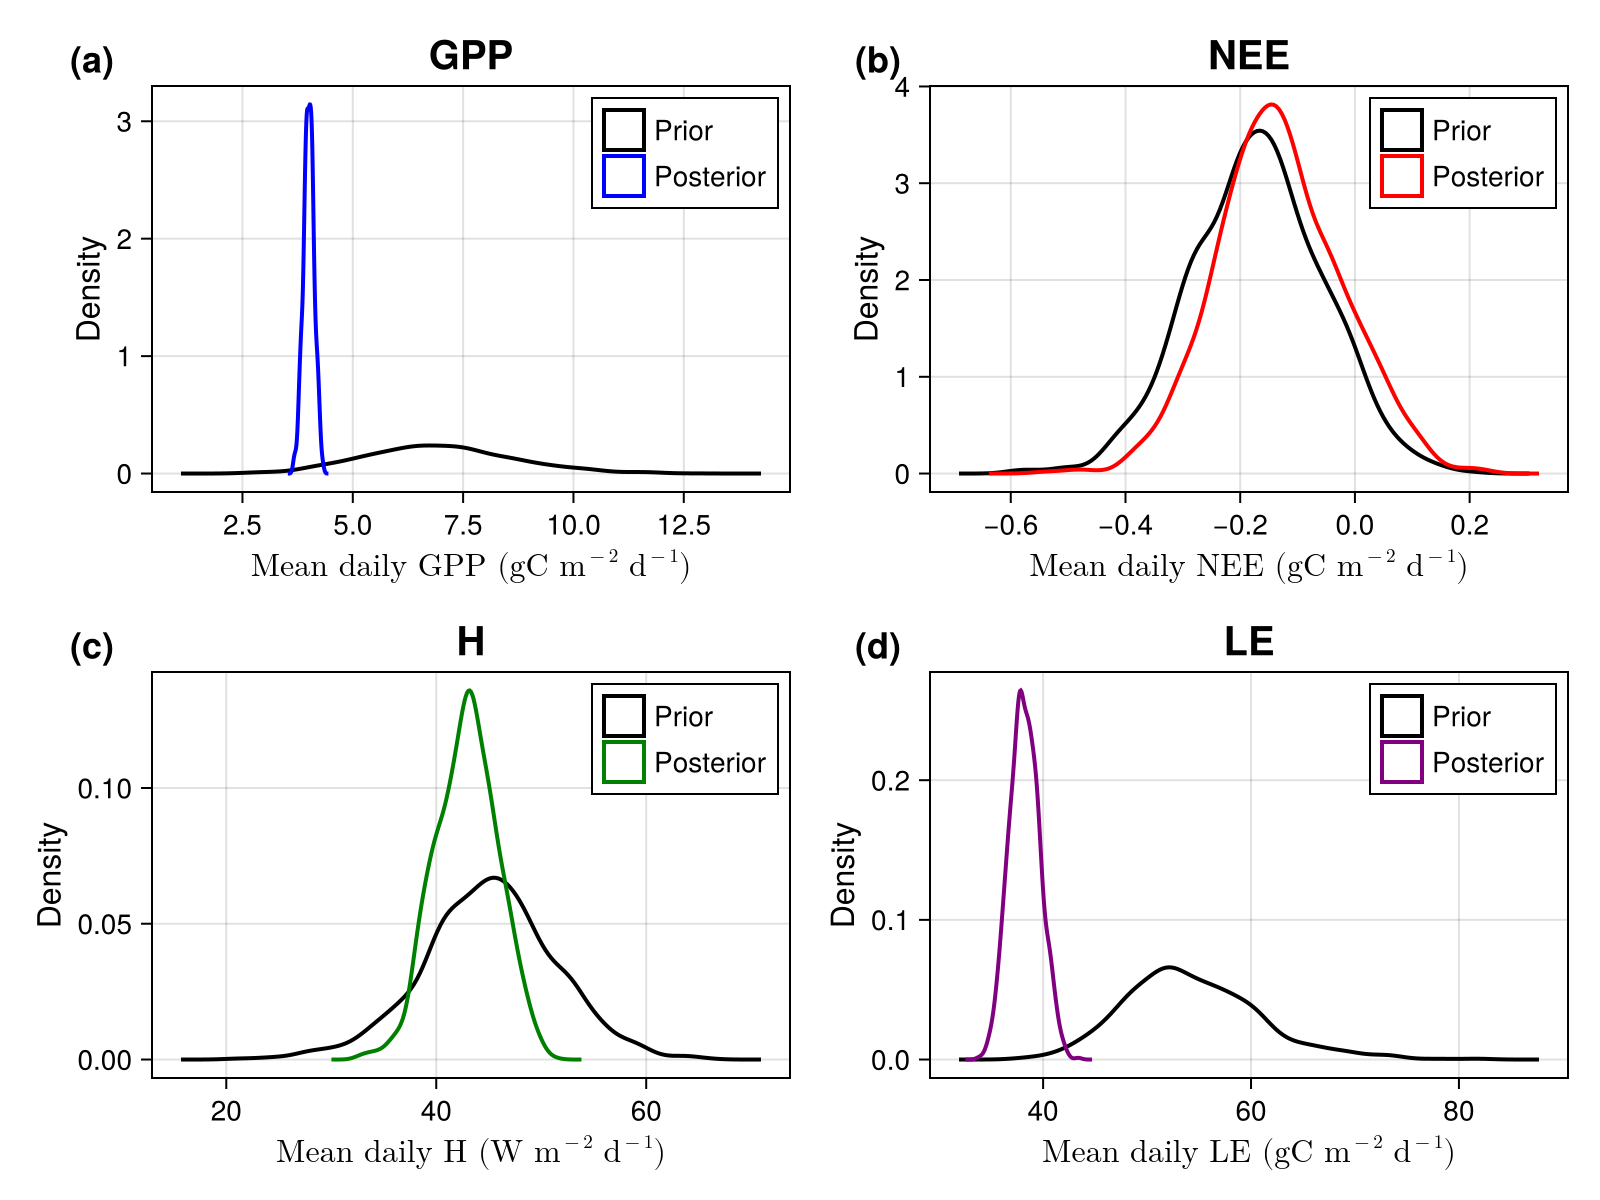

In [68]:
using CairoMakie
total_gpp   = mean(y_sim_1_1, dims=1) |> vec
total_nee   = mean(y_sim_2_2, dims=1) |> vec
total_h   = mean(y_sim_3_3, dims=1) |> vec
total_le   = mean(y_sim_4_4, dims=1) |> vec
total_gpp_prior = mean(y_sim_1_1_prior, dims=1) |> vec
total_nee_prior = mean(y_sim_2_2_prior, dims=1) |> vec
total_h_prior = mean(y_sim_3_3_prior, dims=1) |> vec
total_le_prior = mean(y_sim_4_4_prior, dims=1) |> vec

fig = Figure(size=(800, 600))

# US-Me2
ax1 = Axis(fig[1, 1], xlabel=L"\mathrm{Mean\ daily\ GPP\ (gC\ m^{-2}\ d^{-1})}", ylabel="Density", title="GPP",titlesize=20, xlabelsize=16, ylabelsize=16)
CairoMakie.density!(ax1, total_gpp_prior, color=(:blue,0.0), strokecolor=:black, strokewidth=2, label="Prior")
CairoMakie.density!(ax1, total_gpp, color=(:blue,0.0), strokecolor=:blue, strokewidth=2, label="Posterior")
Label(fig[1, 1, TopLeft()], "(a)", fontsize=18, font=:bold)
#CairoMakie.ylims!(ax1, -0.2, 3.5) 
#CairoMakie.xlims!(ax1, 0, 15)
# US-Blo
ax2 = Axis(fig[1, 2], xlabel=L"\mathrm{Mean\ daily\ NEE\ (gC\ m^{-2}\ d^{-1})}", ylabel="Density", title="NEE",titlesize=20, xlabelsize=16, ylabelsize=16)
CairoMakie.density!(ax2, total_nee_prior, color=(:red,0.0), strokecolor=:black, strokewidth=2, label="Prior")
CairoMakie.density!(ax2, total_nee, color=(:red,0.0), strokecolor=:red, strokewidth=2, label="Posterior")
Label(fig[1, 2, TopLeft()], "(b)", fontsize=18, font=:bold)
#CairoMakie.ylims!(ax2, -0.2, 3.5) 
#CairoMakie.xlims!(ax2, 0, 12)
# US-NR1
ax3 = Axis(fig[2, 1], xlabel=L"\mathrm{Mean\ daily\ H\ (W\ m^{-2}\ d^{-1})}", ylabel="Density", title="H",titlesize=20, xlabelsize=16, ylabelsize=16)
CairoMakie.density!(ax3, total_h_prior, color=(:green,0.0), strokecolor=:black, strokewidth=2, label="Prior")
CairoMakie.density!(ax3, total_h, color=(:green,0.0), strokecolor=:green, strokewidth=2, label="Posterior")
Label(fig[2,1, TopLeft()], "(c)", fontsize=18, font=:bold)
#CairoMakie.ylims!(ax3, -0.2, 3.5) 
#CairoMakie.xlims!(ax3, 0, 5)
ax4 = Axis(fig[2, 2], xlabel=L"\mathrm{Mean\ daily\ LE\ (gC\ m^{-2}\ d^{-1})}", ylabel="Density", title="LE",titlesize=20, xlabelsize=16, ylabelsize=16)
CairoMakie.density!(ax4, total_le_prior, color=(:purple,0.0), strokecolor=:black, strokewidth=2, label="Prior")
CairoMakie.density!(ax4, total_le, color=(:purple,0.0), strokecolor=:purple, strokewidth=2, label="Posterior")
Label(fig[2, 2, TopLeft()], "(d)", fontsize=18, font=:bold)
#CairoMakie.ylims!(ax3, -0.2, 3.5) 
axislegend(ax1; position=:rt)
axislegend(ax2; position=:rt)
axislegend(ax3; position=:rt)
axislegend(ax4; position=:rt)
fig


In [127]:
save("figS8_20260207.pdf",fig)

CairoMakie.Screen{PDF}


In [69]:
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
   # β_0=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_1(θ,N_PCA)
    err=a1*randn(length(m))
    y = β_1*m +err
    #y=err
end

sample_observation (generic function with 1 method)

In [70]:
fig = Figure(size= (1000, 750));

In [78]:
# Simulate observations

y_sim_1_1 = simulate_observations(180, p_samp1, model_1, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]
# Create figure and axis
#l = fig[1, 1] = GridLayout()
ax1 = Axis(fig[1, 1], xlabel = "", ylabel = "GPP",title=L"\mathbf{\mathrm{GPP (gC m^{-2} d^{-1})}}",xticks=(xvalues, xlabels),titlefont="Arial")
CairoMakie.ylims!(ax1, -5, 15)
# Add plots
p2=band!(ax1, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
p4=lines!(ax1, time1[15:10:1805], GPP_01_be_ens, color = :blue, linewidth = 4, label = "")
p3=lines!(ax1, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
p5=GLMakie.scatter!(ax1, time1[15:10:1805], GPP_01,  markersize=6,color = :green, label = "FLUXNET")
rmse_value = rmse(GPP_01, y_sim_1_1_m)
text!(ax1, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))

legend=Legend(fig,[p2,p3,p4,p5], ["95% interval","mean","best estimate","FLUXNET"],tellheight = false, halign =:left, valign =:top, orientation = :horizontal, framevisible = false)
fig[5,2] = legend
legend.width = Relative(2.4)

fig[1,1]=ax1

Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [80]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp2, model_1, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax2 = Axis(fig[2, 1], xlabel = "", ylabel = "NEE", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax2, -5, 15)
# Add plots
p2=band!(ax2, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax2, time1[15:10:1805], GPP_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax2, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax2, time1[15:10:1805], GPP_01, markersize=6,color = :green, label = "")
rmse_value = rmse(GPP_01, y_sim_1_1_m)
text!(ax2, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[2,1]=ax2


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [81]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp3, model_1, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax3 = Axis(fig[3, 1], xlabel = "", ylabel = "H", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax3, -5, 15)
# Add plots
p2=band!(ax3, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax3, time1[15:10:1805], GPP_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax3, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax3, time1[15:10:1805], GPP_01, markersize=6,color = :green, label = "")
rmse_value = rmse(GPP_01, y_sim_1_1_m)
text!(ax3, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[3,1]=ax3


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [82]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp4, model_1, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end
# Create figure and axis

ax4 = Axis(fig[4, 1], xlabel = "year", ylabel = "LE", title = "")
CairoMakie.ylims!(ax4, -5, 15)
# Add plots
p2=band!(ax4, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax4, time1[15:10:1805], GPP_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax4, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax4, time1[15:10:1805], GPP_01, markersize=6,color = :green, label = "")
rmse_value = rmse(GPP_01, y_sim_1_1_m)
text!(ax4, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[4,1]=ax4


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [83]:
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
   # β_0=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_2(θ,N_PCA)
   # err=σ^2*randn(length(m))
    err=a2*randn(length(m))
    #y = β_0.+β_1*m +err
    y = β_1*m +err
    #y=err
end

sample_observation (generic function with 1 method)

In [85]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp1, model_2, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax5 = Axis(fig[1, 2], xlabel = "", ylabel = "", title=L"\mathbf{\mathrm{NEE (gC m^{-2} d^{-1})}}",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax5, -7, 7)
# Add plots
p2=band!(ax5, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax5, time1[15:10:1805], NEE_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax5, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax5, time1[15:10:1805], NEE_01,markersize=6, color = :green, label = "")
rmse_value = rmse_nee(NEE_01, y_sim_1_1_m)
text!(ax5, 2003, 5.6, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))

fig[1,2]=ax5


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [86]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp2, model_2, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax6= Axis(fig[2, 2], xlabel = "", ylabel = "", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax6, -7, 7)
# Add plots
p2=band!(ax6, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax6, time1[15:10:1805], NEE_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax6, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax6, time1[15:10:1805], NEE_01,markersize=6, color = :green, label = "")
rmse_value = rmse_nee(NEE_01, y_sim_1_1_m)
text!(ax6, 2003, 5.6, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[2,2]=ax6


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [88]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp3, model_2, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end
xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax7 = Axis(fig[3, 2], xlabel = "", ylabel = "", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax7, -7, 7)
# Add plots
p2=band!(ax7, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax7, time1[15:10:1805], NEE_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax7, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax7, time1[15:10:1805], NEE_01,markersize=6, color = :green, label = "")
rmse_value = rmse_nee(NEE_01, y_sim_1_1_m)
text!(ax7, 2003, 5.6, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[3,2]=ax7


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [89]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp4, model_2, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end


# Create figure and axis

ax8 = Axis(fig[4, 2], xlabel = "year", ylabel = "", title = "")
CairoMakie.ylims!(ax8, -7, 7)
# Add plots
p2=band!(ax8, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax8, time1[15:10:1805], NEE_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax8, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax8, time1[15:10:1805], NEE_01,markersize=6, color = :green, label = "")
rmse_value = rmse_nee(NEE_01, y_sim_1_1_m)
text!(ax8, 2003, 5.6, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[4,2]=ax8


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [90]:
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_3(θ,N_PCA)
    err=a3*randn(length(m))
    y = β_1*m +err
end

sample_observation (generic function with 1 method)

In [92]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp1, model_3, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax9 = Axis(fig[1, 3], xlabel = "", ylabel = "",title=L"\mathbf{\mathrm{H (W m^{-2})}}",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax9,  -120, 250)
# Add plots
p2=band!(ax9, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax9, time1[15:10:1805], FSH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax9, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax9, time1[15:10:1805], FSH_01,markersize=6, color = :green, label = "")
rmse_value = rmse(FSH_01, y_sim_1_1_m)
text!(ax9, 2003, 213.2, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[1,3]=ax9


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [93]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp2, model_3, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax10 = Axis(fig[2, 3], xlabel = "", ylabel = "", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax10, -120, 250)
# Add plots
p2=band!(ax10, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax10, time1[15:10:1805], FSH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax10, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax10, time1[15:10:1805], FSH_01, markersize=6,color = :green, label = "")
rmse_value = rmse(FSH_01, y_sim_1_1_m)
text!(ax10, 2003, 213.2, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[2,3]=ax10


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [94]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp3, model_3, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax11 = Axis(fig[3, 3], xlabel = "", ylabel = "", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax11, -120, 250)
# Add mean line
p2=band!(ax11, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))

lines!(ax11, time1[15:10:1805], FSH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax11, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax11, time1[15:10:1805], FSH_01, markersize=6,color = :green, label = "")
rmse_value = rmse(FSH_01, y_sim_1_1_m)
text!(ax11, 2003, 213.2, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[3,3]=ax11


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [95]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp4, model_3, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xticks = ([2003, 2005, 2007], ["", "", ""])

# Create figure and axis

ax12 = Axis(fig[4, 3], xlabel = "year", ylabel = "", title = "")
CairoMakie.ylims!(ax12, -120, 250)
# Add plots
p2=band!(ax12, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax12, time1[15:10:1805], FSH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax12, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax12, time1[15:10:1805], FSH_01, markersize=6,color = :green, label = "")
rmse_value = rmse(FSH_01, y_sim_1_1_m)
text!(ax12, 2003, 213.2, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[4,3]=ax12


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [96]:
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_4(θ,N_PCA)
    err=a4*randn(length(m))
    y = β_1*m +err
end

sample_observation (generic function with 1 method)

In [97]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp1, model_4, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax13 = Axis(fig[1, 4], xlabel = "", ylabel = "",title=L"\mathbf{\mathrm{LE (W m^{-2})}}",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax13,-40, 180)
# Add plots
p2=band!(ax13, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax13, time1[15:10:1805], LH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax13, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
rmse_value = rmse(LH_01, y_sim_1_1_m)
text!(ax13, 2003, 158, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
GLMakie.scatter!(ax13, time1[15:10:1805], LH_01, markersize=6,color = :green, label = "")
fig[1,4]=ax13

Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Scatter{Tuple{Vector{Point{2, Float64}}}}


In [98]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp2, model_4, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax14 = Axis(fig[2, 4], xlabel = "", ylabel = "", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax14, -40, 180)
# Add plots
p2=band!(ax14, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax14, time1[15:10:1805], LH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax14, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax14, time1[15:10:1805], LH_01, markersize=6,color = :green, label = "")
rmse_value = rmse(LH_01, y_sim_1_1_m)
text!(ax14, 2003, 158, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[2,4]=ax14


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [99]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp3, model_4, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax15 = Axis(fig[3,4], xlabel = "", ylabel = "", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax15, -40, 180)
# Add plots
p2=band!(ax15, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax15, time1[15:10:1805], LH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax15, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax15, time1[15:10:1805], LH_01,markersize=6, color = :green, label = "")
rmse_value = rmse(LH_01, y_sim_1_1_m)
text!(ax15, 2003, 158, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[3,4]=ax15


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [100]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp4, model_4, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xticks = ([2003, 2005, 2007], ["", "", ""])

# Create figure and axis

ax16 = Axis(fig[4,4], xlabel = "year", ylabel = "", title = "")
CairoMakie.ylims!(ax16, -40, 180)
# Add plots
p2=band!(ax16, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax16, time1[15:10:1805], LH_01_be_ens, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax16, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax16, time1[15:10:1805], LH_01,markersize=6, color = :green, label = "")
rmse_value = rmse(LH_01, y_sim_1_1_m)
text!(ax16, 2003, 158, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[4,4]=ax16


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


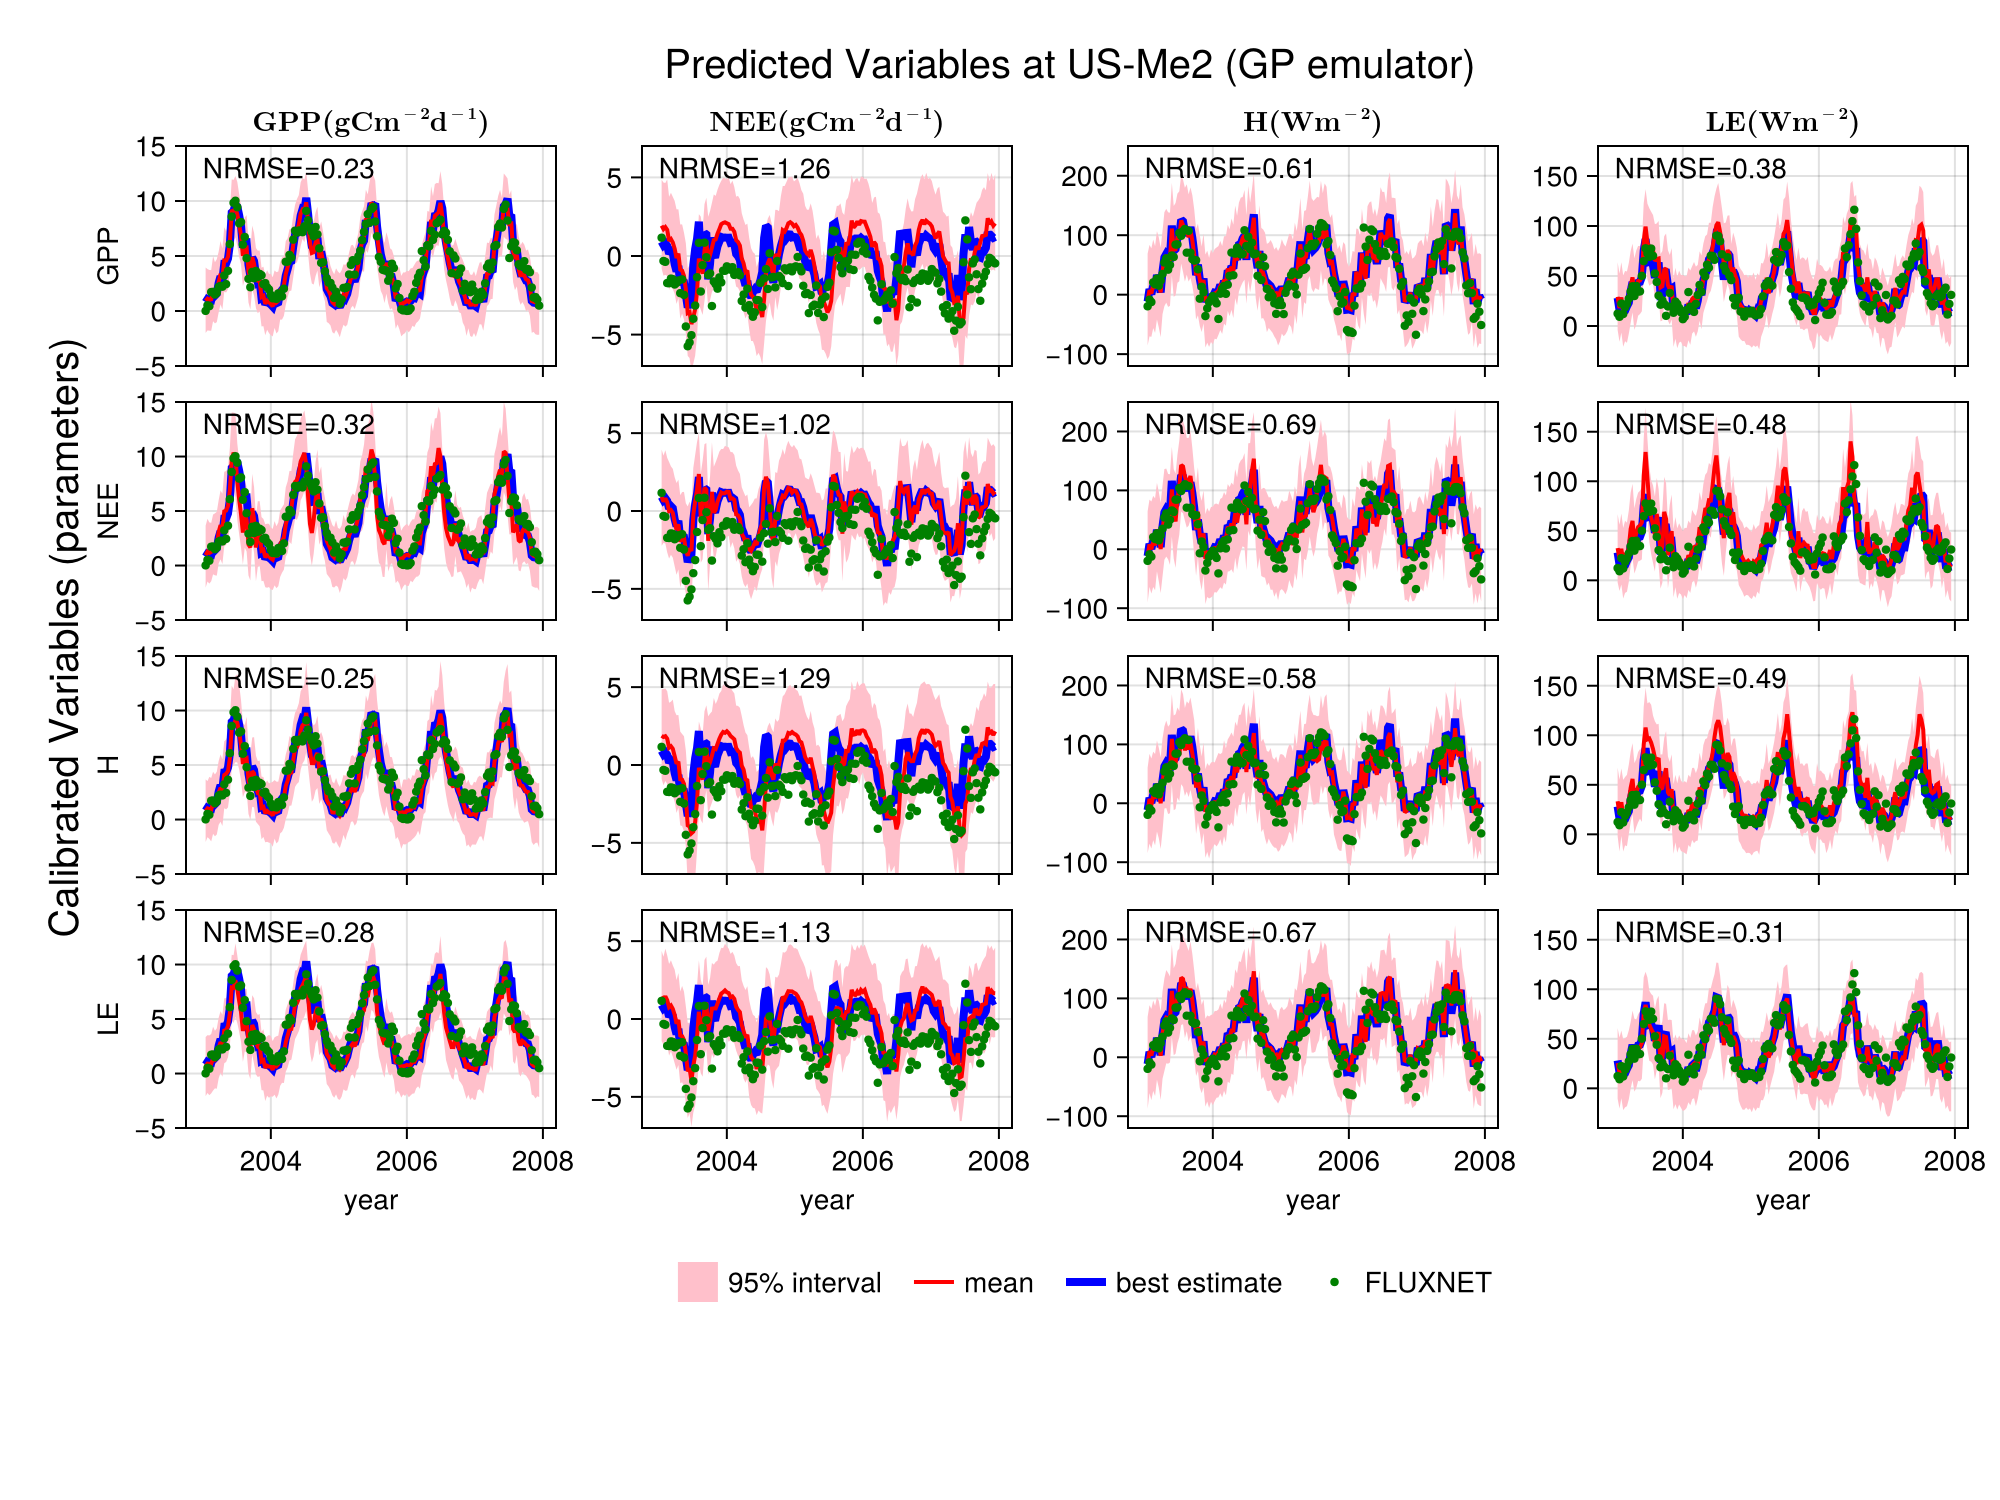

In [101]:
Label(fig[1,2:3,Top()], "Predicted Variables at US-Me2 (GP emulator)", fontsize=20, padding=(4, 4, 30, 4))
Label(fig[2:3,1,Left()], "Calibrated Variables (parameters)", rotation=π/2, fontsize=20, padding=(4, 50, 4, 4))
fig

In [102]:
save("fig10_var_4_4_1000_fluxnet_nobeta0_1_20260207_markersize6.pdf",fig)

CairoMakie.Screen{PDF}
